# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [361]:
import matplotlib.pyplot as plt
import torch

In [362]:
import numpy as np

def onehot_dna(dna: str) -> np.ndarray:
    res =  np.array(list(dna)).reshape(-1, 1) == np.array(['A', 'C', 'G', 'T'])
    return res.astype(int)

In [363]:
onehot_dna('AATC')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.



By looking at the Wikipedia page of the Jund transcription factor, explain what is the use of such protein 

JunD is a protein that helps protect cells from aging and death by working with the AP1 complex. It also interacts with other proteins and has a variant, ΔJunD, that affects addiction-related brain changes.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

The data is available here : https://drive.google.com/drive/folders/1-nrTvNvEZo6Px1pnT7IeotKZR7p365UJ?usp=sharing

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.


In [364]:
import joblib

In [365]:
y_train = joblib.load('tfbind/y_train.joblib')
X_train = joblib.load('tfbind/X_train.joblib')
y_test = joblib.load('tfbind/y_test.joblib')
X_test = joblib.load('tfbind/X_test.joblib')

In [366]:
''' Tests X_train, y_train '''
assert(X_train.shape == (4672, 101, 4))
assert(y_train.shape ==(4672, 1))

There are 4672 segment in the training set

In [367]:
''' Tests X_test, y_test'''
assert(X_test.shape == (584, 101, 4))
assert(y_test.shape ==(584, 1))


There are 584 segment in the test set

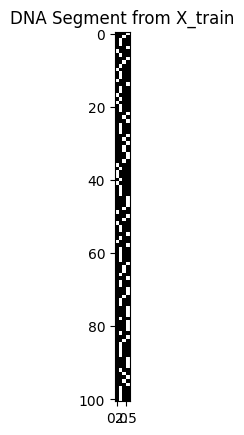

In [368]:
# Display a DNA segment from X_train
plt.imshow(X_train[0], cmap='gray')
plt.title('DNA Segment from X_train')
plt.show()

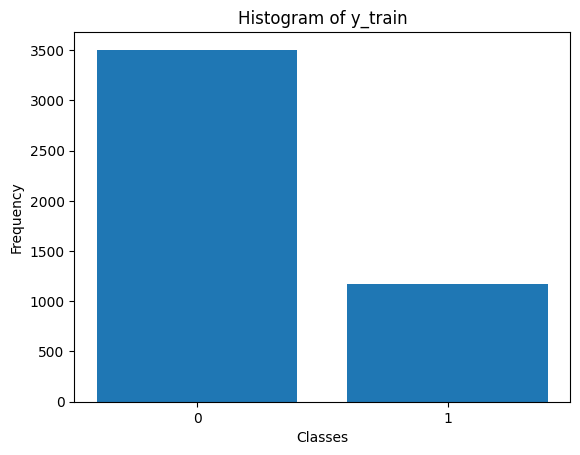

In [369]:
unique_values, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_values, counts)
plt.title('Histogram of y_train')
plt.xlabel('Classes')
plt.xticks(unique_values)
plt.ylabel('Frequency')
plt.show()

# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [370]:
y_train.shape
# Balance the dataset to have the same number of class 1 and 0
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

np.random.shuffle(class_0_indices)
balanced_class_0_indices = class_0_indices[:len(class_1_indices)]

balanced_indices = np.concatenate((balanced_class_0_indices, class_1_indices))

np.random.shuffle(balanced_indices)

# Create balanced X_train and y_train
X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [371]:
X_train_ts = torch.tensor(X_train_balanced, dtype=torch.float32).view(-1, 4, 101)
y_train_ts = torch.tensor(y_train_balanced, dtype=torch.float32)

In [372]:
# ''' Tests X_train_ts, y_train_ts '''
# assert(type(X_train_ts) is torch.Tensor)
# assert(type(y_train_ts) is torch.Tensor)
# assert(X_train_ts.shape == (4672, 4, 101))


In [373]:
X_test_ts = torch.tensor(X_test, dtype=torch.float32).view(-1, 4, 101)
y_test_ts = torch.tensor(y_test, dtype=torch.float32)

In [374]:
''' Tests the above ToDo. '''
assert(type(X_test_ts) is torch.Tensor)
assert(type(y_test_ts) is torch.Tensor)
assert(X_test_ts.shape == (584, 4, 101))


# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [375]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}

        return sample

In [376]:
train_dataset = DNADataset(X_train_ts, y_train_ts)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = DNADataset(X_test_ts, y_test_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

**train_loader** is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call next()

In [377]:
# Run this to test your data loader
data = next(iter(train_loader))
dna = data['DNA']
label = data['Class']
print("a batch data ", dna.shape)
print("Shape of label", label.shape)

a batch data  torch.Size([16, 4, 101])
Shape of label torch.Size([16, 1])


# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.


2. Apply this layer to **dna_seg** below. What is the size of the output ?


3. [Optional] Display the output by using matplotlib.pyplot.imshow




In [378]:
data = next(iter(train_loader))
dna_seg = data['DNA']
y = data['Class']

In [379]:
conv = torch.nn.Conv1d(4, 16, 3, padding=1)
conv(dna_seg).shape

torch.Size([16, 16, 101])

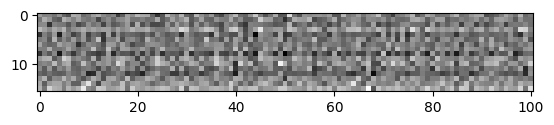

In [380]:
plt.imshow(conv(dna_seg)[0].detach().numpy(), cmap='gray')

# EX 6: Build a model

Create a 3 layer 1-dimensional network to classify the TF binding sites

In [381]:
import torch.nn as nn
import torch.nn.functional as F


class DeepDNA(nn.Module):
    def __init__(self, dim):
        super(DeepDNA, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv1d(4, 16, 3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(64 * (self.dim//8), 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = nn.Sigmoid()(self.fc1(x))
        return x

# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

2. Print out the variable **net** to see detailed information about the model.

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

4. What is the size of the output ?



In [382]:
#data = next(iter(train_loader))
dna_seg = data['DNA']

##### TO DO #######

net = DeepDNA(101)
out = net(dna_seg)

print("the output of the model ", out[:5])

the output of the model  tensor([[0.4756],
        [0.4756],
        [0.4725],
        [0.4735],
        [0.4758]], grad_fn=<SliceBackward0>)


In [383]:
dna_seg.shape

torch.Size([16, 4, 101])

In [384]:
print(net)

DeepDNA(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=768, out_features=1, bias=True)
)


# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [385]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 1e-3)

# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [386]:
def train(net, train_loader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    num_batches = len(train_loader)
    
    for batch_data in train_loader:
        inputs = batch_data['DNA'].to(device)
        labels = batch_data['Class'].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / num_batches
    return epoch_loss

In [387]:
for epoch in range(10):
    loss_epoch = train(net, train_loader, criterion, optimizer, 'cpu')
    print(f'Epoch {epoch} Loss {loss_epoch}')

Epoch 0 Loss 0.6942429534376484
Epoch 1 Loss 0.6937868864568946
Epoch 2 Loss 0.6935497648911934
Epoch 3 Loss 0.6934084761632632
Epoch 4 Loss 0.6933462595286435
Epoch 5 Loss 0.6933365721408635
Epoch 6 Loss 0.6932992763715248
Epoch 7 Loss 0.6932818118023546
Epoch 8 Loss 0.6932683272721016
Epoch 9 Loss 0.6932571681394969


# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [388]:
### TODO ####
def compute_num_correct_pred(y_prob, y_label):
    y_prob = y_prob.detach().numpy()
    y_label = y_label.detach().numpy()
    y_prob = y_prob > 0.5
    y_prob = y_prob.astype(int)
    res: np.ndarray = y_prob == y_label
    res = res.astype(int)
    return sum(res)

In [389]:
out.shape
y.shape

torch.Size([16, 1])


The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [390]:
def test(loader):
  net.eval()

  correct = 0
  with torch.no_grad():
    for data in loader:
      dna = data['DNA']
      y = data['Class']

      out = net(dna)
      correct += compute_num_correct_pred(out, y)
  return correct / len(loader.dataset)

In [391]:
test(train_loader)

array([0.48972603])

# Ex 12: Training the model

The code below allows to train your model on 10 epoches. If all work well, you should see the training loss drop with each epoch.

train the model for 2000 epochs

In [392]:
for epoch in range(2000):
    loss_epoch = train(net, train_loader, criterion, optimizer, 'cpu')
    if epoch % 20 == 0:
        test_acc = test(test_loader)
        train_acc = test(train_loader)
        print(f'Epoch {epoch} train loss {loss_epoch}  - train accuracy {train_acc} - test accuracy {test_acc}')

Epoch 0 train loss 0.693262664014346  - train accuracy [0.48758562] - test accuracy [0.52568493]
Epoch 20 train loss 0.6931161700862728  - train accuracy [0.50085616] - test accuracy [0.5359589]
Epoch 40 train loss 0.6929660921227442  - train accuracy [0.50684932] - test accuracy [0.45890411]
Epoch 60 train loss 0.6928302996779141  - train accuracy [0.52054795] - test accuracy [0.50342466]
Epoch 80 train loss 0.6926943067818472  - train accuracy [0.5239726] - test accuracy [0.51883562]
Epoch 100 train loss 0.6925579142080595  - train accuracy [0.53339041] - test accuracy [0.52739726]
Epoch 120 train loss 0.692429298815662  - train accuracy [0.54965753] - test accuracy [0.45719178]
Epoch 140 train loss 0.6922949323915455  - train accuracy [0.55393836] - test accuracy [0.45547945]
Epoch 160 train loss 0.6921441787726259  - train accuracy [0.56506849] - test accuracy [0.48116438]
Epoch 180 train loss 0.692015776895497  - train accuracy [0.57106164] - test accuracy [0.47945205]
Epoch 200 t

# Ex13 (optional)



1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?



2. The same question for torch.nn.CrossEntropyLoss() loss.  

1. Changes to the Model:
Remove the torch.sigmoid from the final layer of the forward method.
The output of the final layer (self.fc1) should be the raw logits.

2. Modify the final fully connected layer (self.fc1) to output as many values as there are classes (two classes, output 2 logits instead of 1).
Remove any torch.sigmoid or F.softmax from the forward method.